 # 1. Exploración teórica de las señales ECG y variables del dataset
## Contexto del problema

La fibrilación auricular (AFib) es una de las arritmias cardíacas más comunes. Se caracteriza por latidos cardíacos irregulares y, a menudo, rápidos. Su detección oportuna es fundamental, ya que puede prevenir complicaciones graves como accidentes cerebrovasculares, insuficiencia cardíaca y otras enfermedades cardíacas.

Los ECG (electrocardiogramas) son la herramienta estándar para diagnosticar arritmias. Sin embargo, interpretar grandes volúmenes de señales ECG de forma manual es poco escalable. Aquí es donde entra el modelo de ML entrenado para detectar patrones en los datos. Estos modelos pueden ayudar a automatizar el proceso de diagnóstico, reduciendo errores humanos y permitiendo análisis a gran escala, sirviendo de apoyo para el diagnostico de los medicos especializados en el tema.

## Utilidad del modelo de Machine Learning

El modelo a desarrollar tendrá como objetivo:

- Clasificar segmentos de señal ECG usando solo información extraída de los intervalos RR.

- Distinguir entre ritmo normal y fibrilación auricular.

- Servir como base para un sistema de monitoreo automatizado que pueda alertar de forma temprana al paciente o médico tratante.

Esto se alinea con aplicaciones clínicas reales, donde dispositivos portátiles como smartwatches pueden detectar alteraciones cardíacas en tiempo real.


## Importancia de cada variable del dataset

| Variable     | Descripción técnica                                                                                   | Relevancia para la clasificación                                                                                      |
| ------------ | ----------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| **mean\_rr** | Promedio de los intervalos RR (en milisegundos). Refleja el **ritmo cardíaco promedio** del segmento. | En AFib suele haber un promedio más bajo (taquicardia) o muy variable. En ritmo normal es más constante.              |
| **std\_rr**  | Desviación estándar de los intervalos RR. Indica la **variabilidad del ritmo**.                       | En AFib hay una **alta variabilidad**; en ritmo normal, menor. Muy útil como separador.                               |
| **skew\_rr** | Asimetría de la distribución de RR. Mide si los intervalos son más frecuentes en un extremo.          | AFib puede producir distribuciones asimétricas debido a latidos muy cortos o largos intercalados.                     |
| **kurt\_rr** | Curtosis de la distribución de RR. Mide la **concentración de valores alrededor de la media**.        | En AFib, los valores pueden estar más dispersos, lo que lleva a curtosis baja; en ritmo normal, pueden agruparse más. |
| **label**    | Clase del segmento: `Normal` o `AFib`.                                                                | Etiqueta supervisada para entrenar y evaluar el modelo.                                                               |


En lugar de procesar señales crudas (que es complejo y requiere alto poder de cómputo), este enfoque reduce la dimensionalidad y complejidad al utilizar características estadísticas ya extraídas. Esto tiene varias ventajas:

- Permite entrenar modelos simples con pocos datos.

- Es interpretable: cada atributo tiene un significado clínico claro.




## Visualización del electrocardiograma




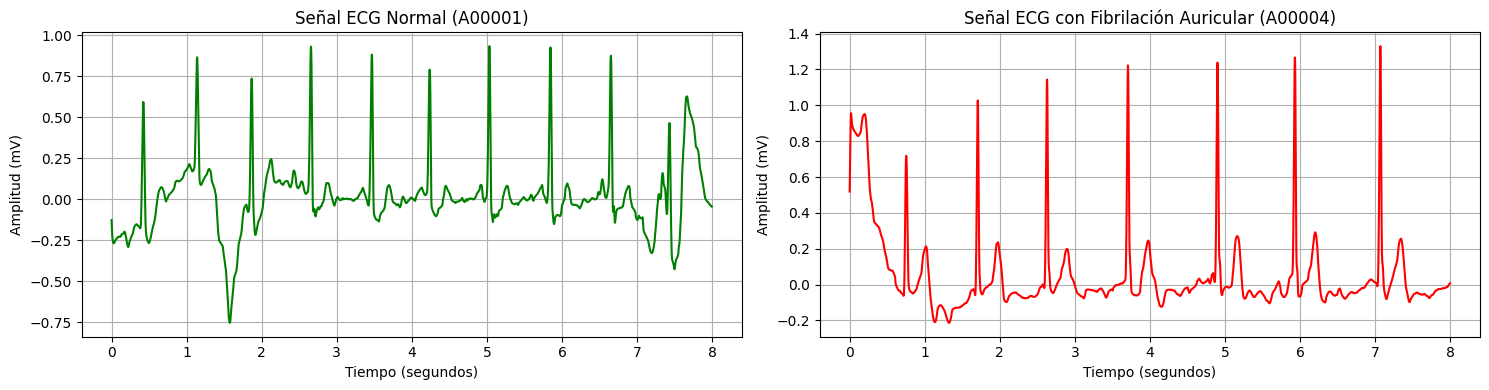

In [34]:
import wfdb
import matplotlib.pyplot as plt
import os
import numpy as np

# Ruta donde están los archivos .mat y .hea
ruta_carpeta = './proyecto/training2017'  # Ajusta esta ruta

# Registros de ejemplo: uno normal y otro con AFib
registro_normal = 'A00001'
registro_afib = 'A00004'

# Cargar registros
record_n = wfdb.rdrecord(os.path.join(ruta_carpeta, registro_normal))
record_a = wfdb.rdrecord(os.path.join(ruta_carpeta, registro_afib))

# Señales y frecuencias de muestreo
signal_n = record_n.p_signal[:, 0]
signal_a = record_a.p_signal[:, 0]
fs_n = int(record_n.fs)
fs_a = int(record_a.fs)

# Definir ventana de tiempo para mostrar (segundos)
duracion_segundos = 8

# Crear eje de tiempo en segundos para cada señal (solo la ventana)
t_n = np.arange(len(signal_n)) / fs_n
t_a = np.arange(len(signal_a)) / fs_a

# Limitar señales y tiempo a la duración deseada
max_muestra_n = min(len(signal_n), fs_n * duracion_segundos)
max_muestra_a = min(len(signal_a), fs_a * duracion_segundos)

t_n = t_n[:max_muestra_n]
signal_n = signal_n[:max_muestra_n]

t_a = t_a[:max_muestra_a]
signal_a = signal_a[:max_muestra_a]

# Graficar
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(t_n, signal_n, color='green')
plt.title(f'Señal ECG Normal ({registro_normal})')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud (mV)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_a, signal_a, color='red')
plt.title(f'Señal ECG con Fibrilación Auricular ({registro_afib})')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud (mV)')
plt.grid(True)

plt.tight_layout()
plt.show()


## Procesamiento de las señales a variables


In [41]:
import wfdb
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import skew, kurtosis

# Función para filtrar la señal ECG
def filtrar_senal(señal, fs):
    b, a = butter(1, [0.5 / (fs / 2), 40 / (fs / 2)], btype='band')
    return filtfilt(b, a, señal)

# Ruta y carga de referencias
ruta_carpeta = './proyecto/training2017'
ruta_referencia = os.path.join(ruta_carpeta, 'REFERENCE.csv')
df_referencia = pd.read_csv(ruta_referencia, header=None, names=['file', 'clase'])

mapa_clases = {
    'N': 'Normal',
    'A': 'AFib',
    'O': 'Otro',
    '~': 'Ruido'
}
df_referencia['label'] = df_referencia['clase'].map(mapa_clases)
df_referencia = df_referencia[df_referencia['label'].isin(['Normal', 'AFib'])]

resultados = []

for idx, fila in df_referencia.iterrows():
    archivo = fila['file']
    etiqueta = fila['label']

    try:
        registro = wfdb.rdrecord(os.path.join(ruta_carpeta, archivo))
        señal = registro.p_signal[:, 0]
        fs = int(registro.fs)

        # Filtrar y normalizar señal
        señal_filtrada = filtrar_senal(señal, fs)
        señal_norm = (señal_filtrada - np.mean(señal_filtrada)) / np.std(señal_filtrada)

        # Detección de picos R
        picos, _ = find_peaks(señal_norm, distance=fs*0.3, prominence=0.2)

        if len(picos) < 6:
            print(f"Advertencia: pocos picos detectados en {archivo}. Saltando.")
            continue

        # Intervalos RR (en ms)
        rr_intervals = np.diff(picos) * (1000 / fs)

        # Características estadísticas
        mean_rr = np.mean(rr_intervals)
        std_rr = np.std(rr_intervals)
        skew_rr = skew(rr_intervals)
        kurt_rr_val = kurtosis(rr_intervals)

        resultados.append({
            'file': archivo,
            'mean_rr': mean_rr,
            'std_rr': std_rr,
            'skew_rr': skew_rr,
            'kurt_rr': kurt_rr_val,
            'label': etiqueta
        })

    except Exception as e:
        print(f"Error procesando {archivo}: {e}")

df_caracteristicas = pd.DataFrame(resultados)

# Estadísticas para validación
print(df_caracteristicas.groupby('label')[['mean_rr', 'std_rr']].describe())

# Guardar
df_caracteristicas.to_csv('ecg_rr_features_curado.csv', index=False)



       mean_rr                                                              \
         count        mean         std         min         25%         50%   
label                                                                        
AFib     738.0  510.768708   68.688623  370.000000  461.458333  502.824859   
Normal  5050.0  594.704107  117.945946  336.824458  499.053672  584.908911   

                                 std_rr                                   \
               75%          max   count        mean        std       min   
label                                                                      
AFib    549.280379   877.474747   738.0  133.941337  42.482402  3.558521   
Normal  670.855392  1063.809524  5050.0  170.256733  55.712303  2.749843   

                                                        
               25%         50%         75%         max  
label                                                   
AFib    105.108044  134.150764  161.834727  306.044372  


# Visualización de los datos 

Para la visualización balancearemos los datos, ya que por defecto hay muchas más muestras de normal que de arritmia.

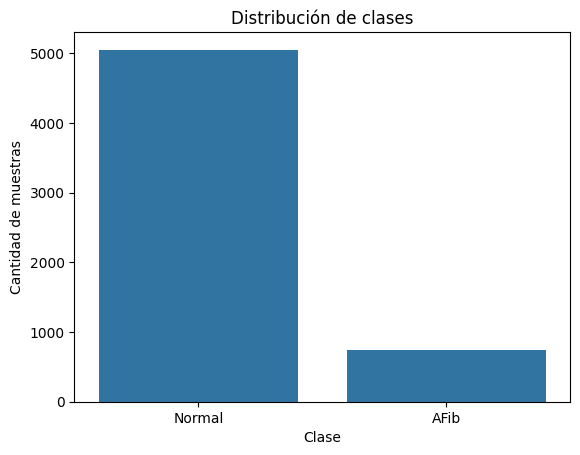

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('ecg_rr_features_curado.csv')

sns.countplot(data=df, x='label')
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad de muestras')
plt.show()

In [50]:
# Balancear el dataset solo para gráficos
min_size = 30
df_balanced = df.groupby('label').sample(n=min_size, random_state=42)
# Tambien descartaremos los datos más extremos (solo para visualización)
df_balanced.describe()

,mean_rr,std_rr,skew_rr,kurt_rr
count,60.000000,60.000000,60.000000,60.000000
mean,537.908850,153.110478,0.480507,0.275115
std,90.874489,55.390500,0.888416,2.418113
min,397.688889,15.760812,-3.507842,-1.766332
25%,467.936955,119.709120,0.148552,-0.852291
50%,517.357049,149.274204,0.574913,-0.415629
75%,604.920635,196.327554,1.050782,0.914813
max,767.619048,266.109047,1.702244,15.693486


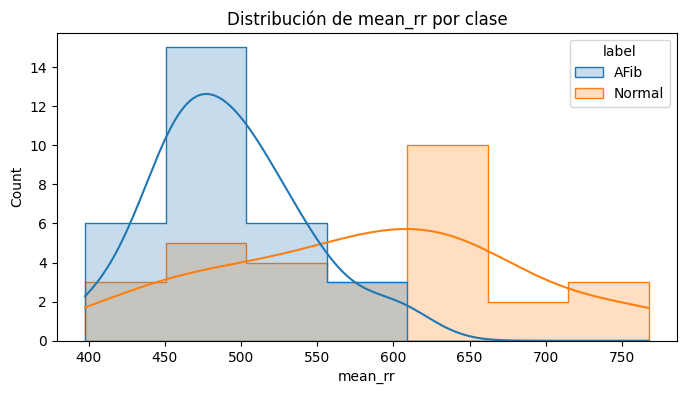

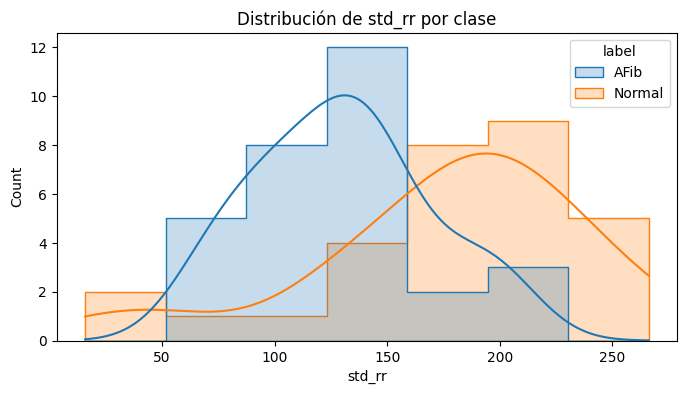

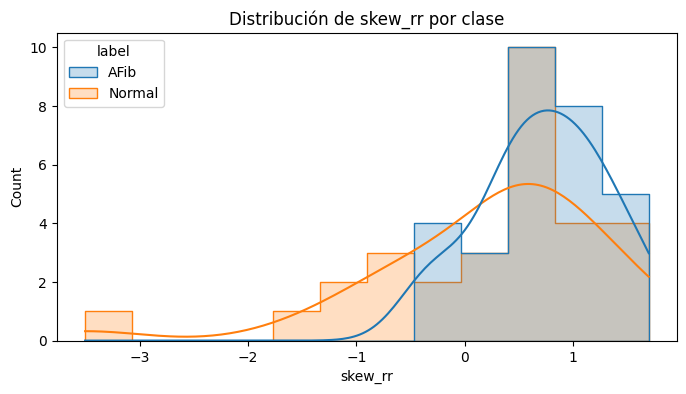

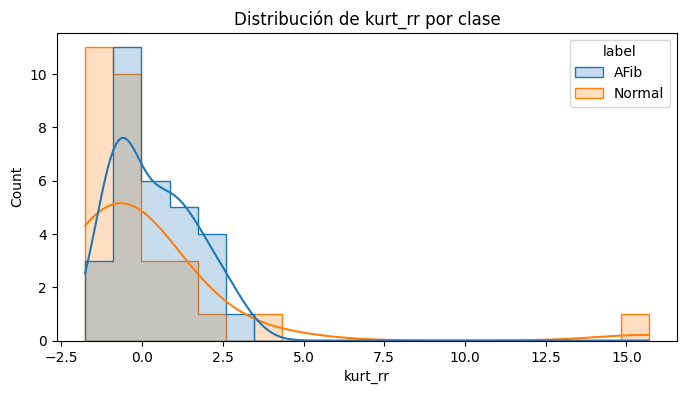

In [51]:
features = ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']

for feature in features:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_balanced, x=feature, hue='label', kde=True, element='step')
    plt.title(f'Distribución de {feature} por clase')
    plt.show()


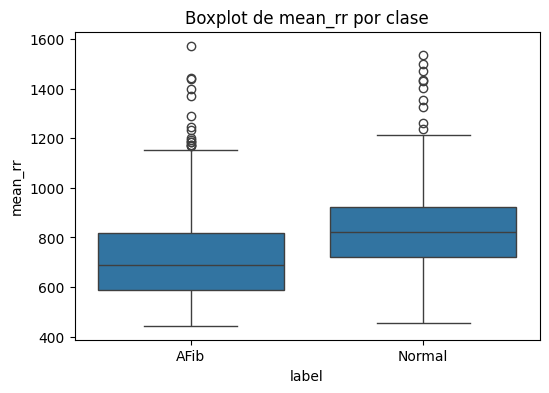

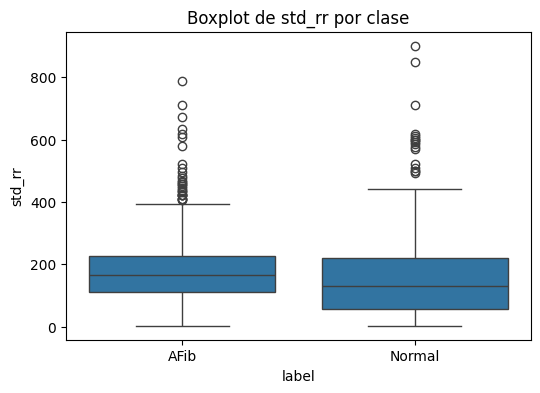

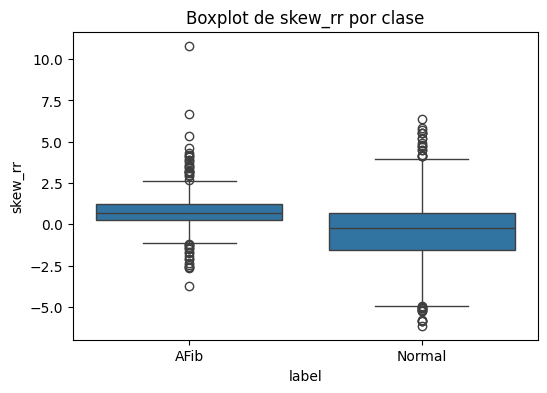

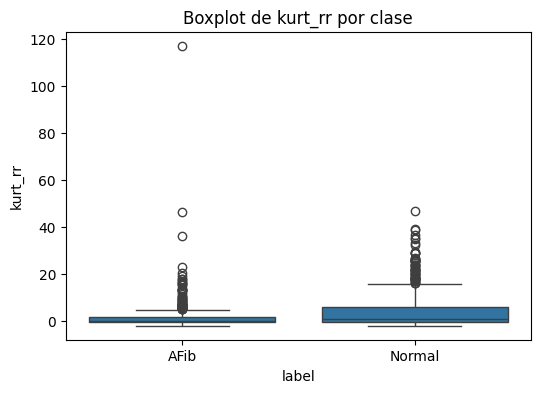

In [24]:
for feature in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_balanced, x='label', y=feature)
    plt.title(f'Boxplot de {feature} por clase')
    plt.show()


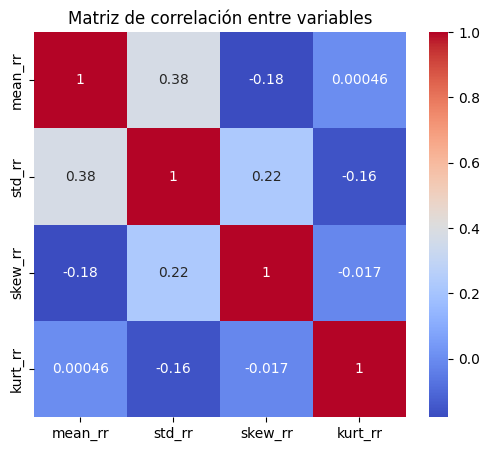

In [25]:
plt.figure(figsize=(6,5))
sns.heatmap(df_balanced[features].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación entre variables')
plt.show()


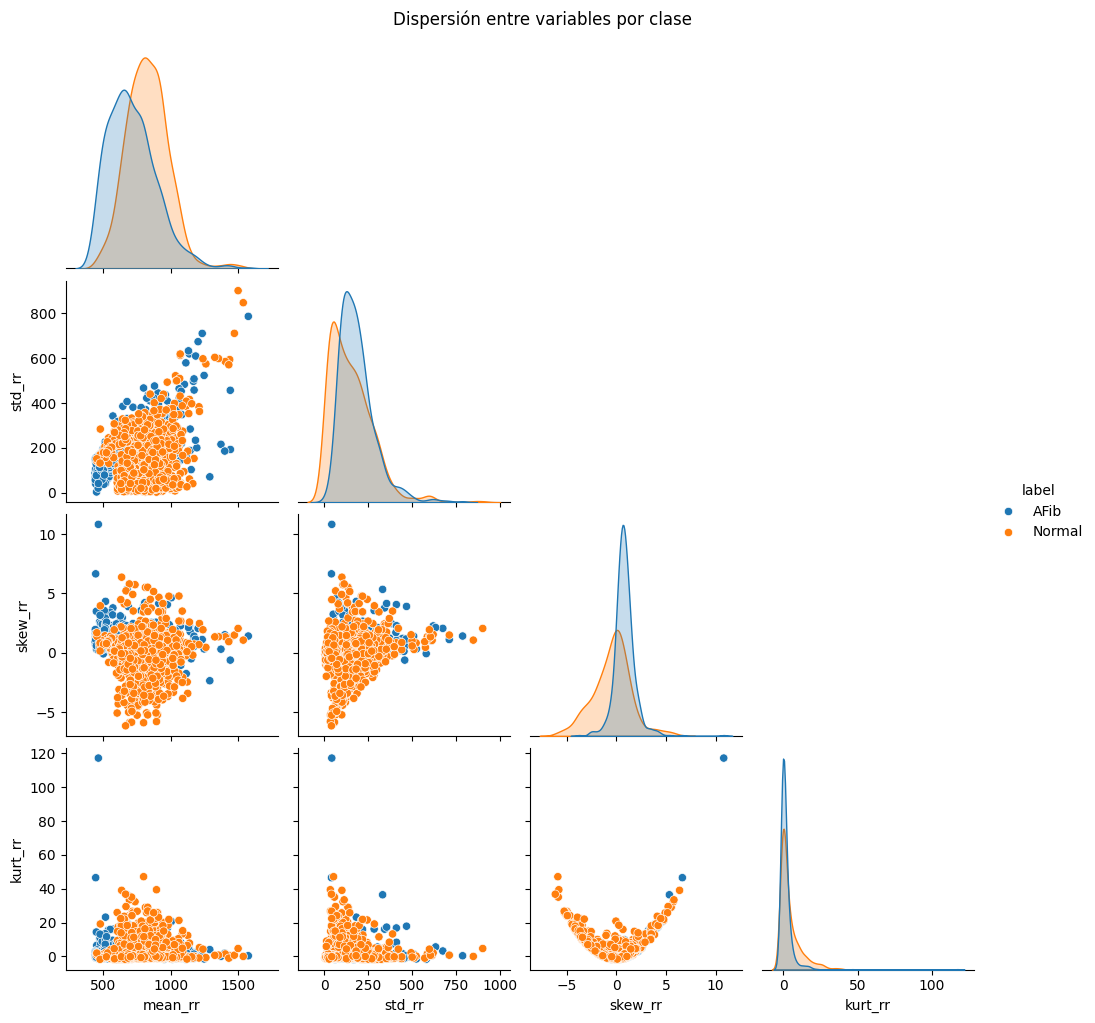

In [26]:
sns.pairplot(df_balanced, vars=features, hue='label', corner=True, diag_kind='kde')
plt.suptitle('Dispersión entre variables por clase', y=1.02)
plt.show()
